## Optimize spatial stratified sampling Tessellation

Author
* Dr. [Daniel Griffith](https://profiles.utdallas.edu/dagriffith)
* Dr. [Yongwan Chun](https://profiles.utdallas.edu/ywchun)
* [Yalin Yang](https://gisyaliny.github.io/)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
import os

## Read data
### DFW CMA

In [2]:
host = "localhost"
database = "spatialSampling"
user = os.getenv('SQL_USER')
password = os.getenv('SQL_PASSWORD')
connection_string = f"postgresql://{user}:{password}@{host}/{database}"
engine = create_engine(connection_string)
insp = inspect(engine)
insp.get_table_names()

['DFW_CMA_300KM_Hexagon', 'spatial_ref_sys', 'DFW_CMA']

In [3]:
sql = 'SELECT * FROM public."DFW_CMA"'
dfw_cma = gpd.read_postgis(sql, con=engine)
dfw_cma = dfw_cma.to_crs(epsg=32138)
dfw_cma.Shape_Area = dfw_cma.area
print(dfw_cma.shape)
dfw_cma.head()

(19, 21)


,GISJOIN,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geom
0,G4000130,40,013,01101794,40013,Bryan,Bryan County,06,H1,G4020,...,20460,None,A,2.342004e+09,102054905.0,+33.9640035,-096.2651348,324324.430753,2.444062e+09,"POLYGON ((792955.077 2278129.472, 792955.362 2..."
1,G4800850,48,085,01383828,48085,Collin,Collin County,06,H1,G4020,...,19100,19124,A,2.178839e+09,115550728.0,+33.1944942,-096.5794280,195281.272759,2.293828e+09,"POLYGON ((796763.996 2193950.719, 796757.978 2..."
2,G4800970,48,097,01383834,48097,Cooke,Cooke County,06,H1,G4020,...,23620,None,A,2.265790e+09,61319327.0,+33.6391964,-097.2103433,299439.594613,2.326772e+09,"POLYGON ((743773.787 2254188.355, 743774.126 2..."
3,G4801130,48,113,01383842,48113,Dallas,Dallas County,06,H1,G4020,...,19100,19124,A,2.261201e+09,91898226.0,+32.7669866,-096.7784238,194013.898402,2.352570e+09,"POLYGON ((754743.028 2147679.133, 754804.527 2..."
4,G4801210,48,121,01383847,48121,Denton,Denton County,06,H1,G4020,...,19100,19124,A,2.275318e+09,189471919.0,+33.2051320,-097.1211403,198961.123604,2.464192e+09,"POLYGON ((744718.508 2195102.423, 744795.176 2..."


### DFW CMA Hexagon (300 km^2)

In [4]:
sql = 'SELECT * FROM public."DFW_CMA_300KM_Hexagon"'
dfw_cma_300km_hexagon = gpd.read_postgis(sql, con=engine)
dfw_cma_300km_hexagon = dfw_cma_300km_hexagon.to_crs(epsg=32138)
dfw_cma_300km_hexagon.Shape_Area = dfw_cma_300km_hexagon.area
print(dfw_cma_300km_hexagon.shape)
dfw_cma_300km_hexagon.head()

(179, 4)


,Shape_Leng,Shape_Area,GRID_ID,geom
0,64474.195886,3.000000e+08,L-15,"POLYGON ((776093.007 2020574.580, 770720.157 2..."
1,64474.195986,3.000000e+08,M-15,"POLYGON ((792211.556 2011268.532, 786838.706 2..."
2,64474.195886,3.000000e+08,N-15,"POLYGON ((808330.105 2020574.580, 802957.255 2..."
3,64474.195886,3.000000e+08,L-14,"POLYGON ((776093.007 2039186.677, 770720.157 2..."
4,64474.195986,3.000000e+08,M-14,"POLYGON ((792211.556 2029880.629, 786838.706 2..."


<Axes: >

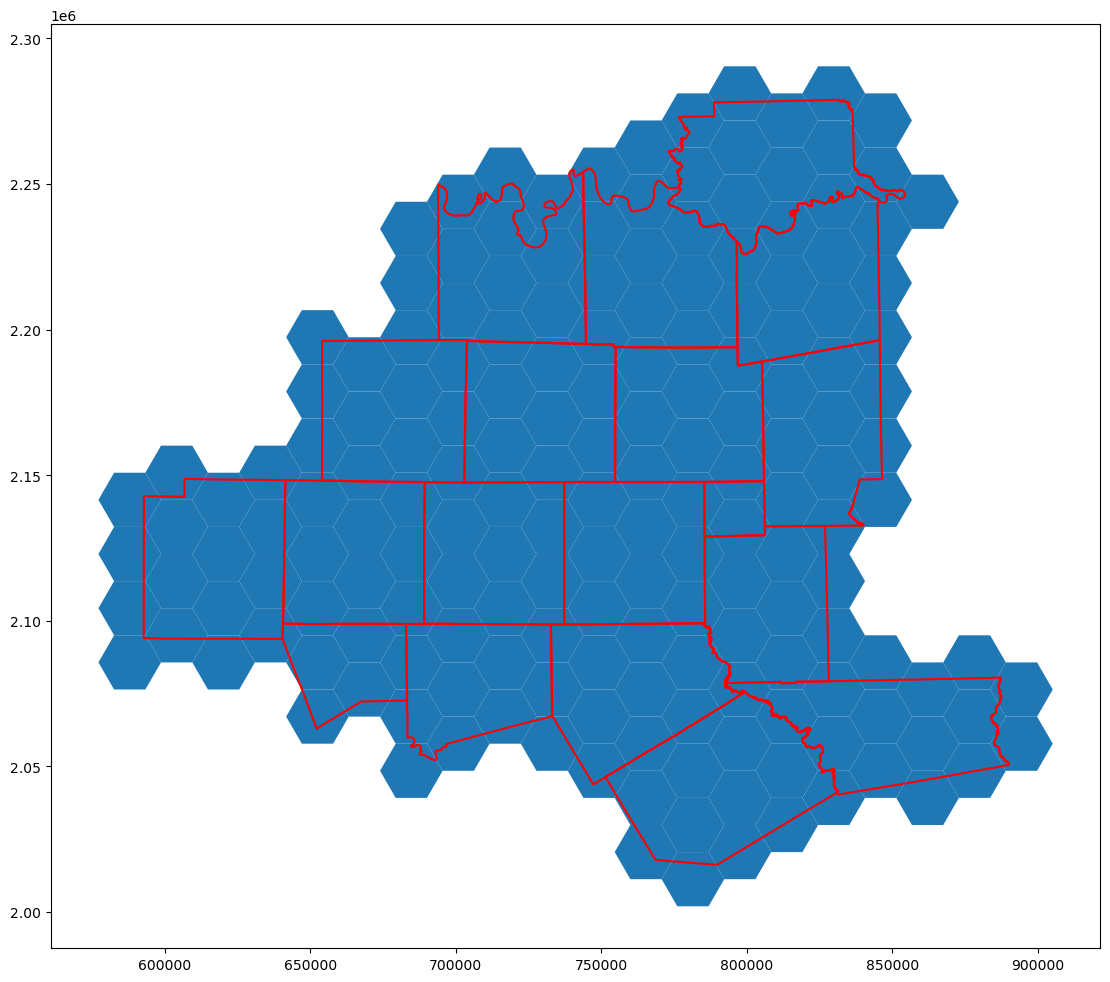

In [5]:
dfw_cma["boundary"] = dfw_cma.boundary
ax = dfw_cma_300km_hexagon["geom"].plot(figsize=(15, 12))
dfw_cma["boundary"].plot(ax=ax, color="red")

## Cutoff by red boundary

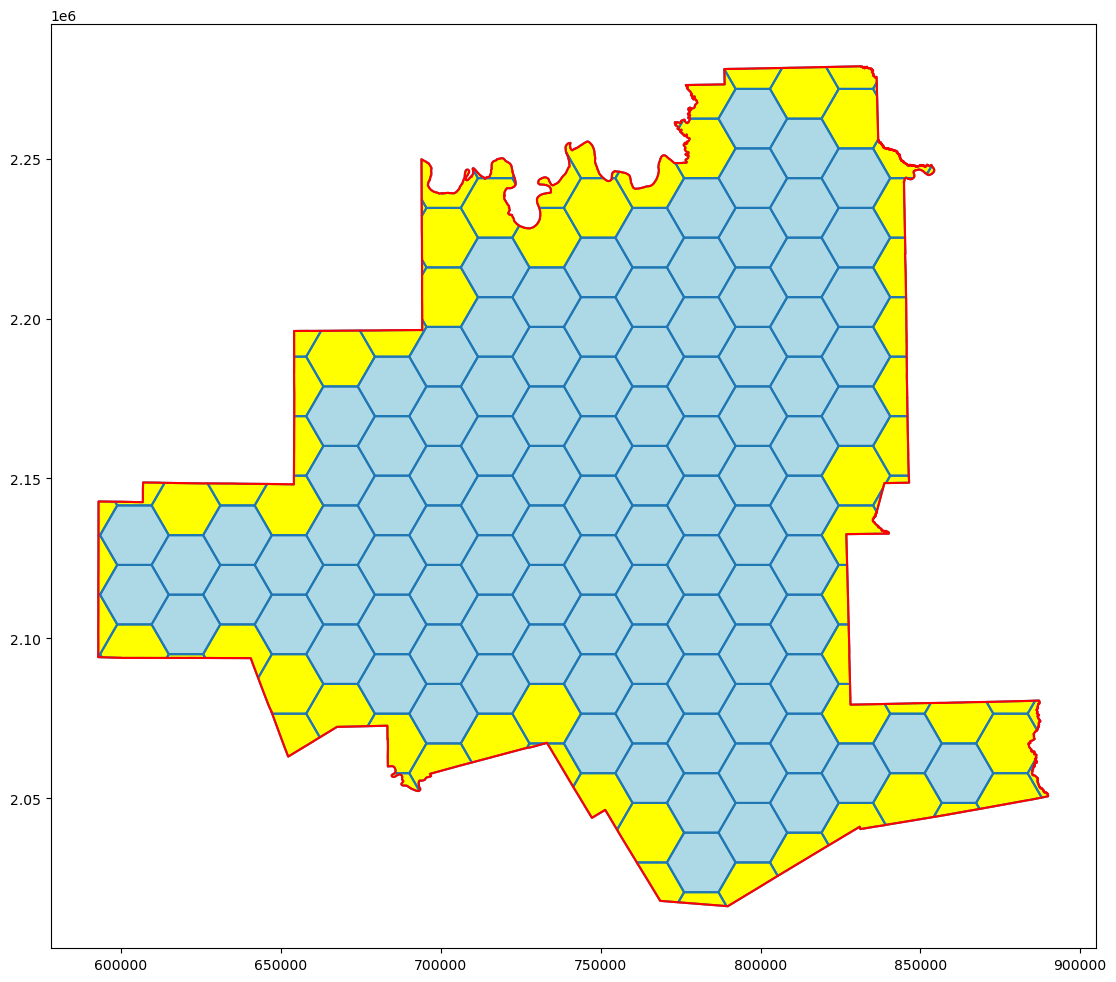

In [6]:
# Dissolve all polygons in dfw_cma into a single boundary polygon
dfw_cma_boundary = dfw_cma.dissolve()

# Clip the dfw_cma_800km_hexagon with the dissolved boundary polygon
clipped_hexagons = gpd.clip(dfw_cma_300km_hexagon, dfw_cma_boundary)
clipped_hexagons["area"] = clipped_hexagons.area

# Filter hexagons with area less than 300 square kilometers
small_hexagons = clipped_hexagons[clipped_hexagons['area'] < 299999990]

# Plotting
fig, ax = plt.subplots(figsize=(15, 12))
clipped_hexagons.plot(ax=ax, color='lightblue', label='Complete hexagons')  # Plot all hexagons
clipped_hexagons.boundary.plot(ax=ax) 
small_hexagons.plot(ax=ax, color='yellow', label='Cut-off hexagons')  # Plot smaller hexagons in green
dfw_cma_boundary.boundary.plot(ax=ax, color="red", label='DFW Boundary' )
plt.show()

In [7]:
small_hexagons["area"].describe()

count    7.400000e+01
mean     1.406795e+08
std      9.577313e+07
min      7.878174e+05
25%      5.251988e+07
50%      1.320315e+08
75%      2.357819e+08
max      2.999232e+08
Name: area, dtype: float64

## Merge cut-off hexagons to 300 km^2
### Without distance constraint

In [8]:
import itertools
import random
import math

In [9]:
def reorder_list(input_list):
    unique_elements = list(set(input_list))
    element_to_index = {element: index for index, element in enumerate(unique_elements)}
    return [element_to_index[element] for element in input_list]

def merge_into_groups(numbers, target_sum, max_iter=100):
    """
    Merge numbers into groups such that each group has a sum closest to the target sum.

    Args:
        numbers (list): List of numbers to be grouped.
        target_sum (float): Target sum for each group.
        max_iter (int): Maximum number of iterations to run.

    Returns:
        list: List indicating the group each number belongs to.
    """
    # Initialize groups randomly
    groups = [i % len(numbers) for i in range(len(numbers))]
    # Initial group sums
    group_sums = [x for x in numbers]

    iter_count = 0
    while iter_count < max_iter:
        iter_count += 1

        # Track if any change occurs in this iteration
        changed = False

        for num_idx, num in enumerate(numbers):
            current_group = groups[num_idx]
            current_sum = group_sums[current_group]

            # Calculate the difference if the number is added to the current group
            best_diff = abs(current_sum - target_sum)
            best_group = current_group
            
            for group in list(set(groups)):
                if group!= current_group:
                    neighbor_sum = group_sums[group]
                    diff_neighbor_group = abs(neighbor_sum + num - target_sum)
                    if diff_neighbor_group < best_diff:
                        best_diff = diff_neighbor_group
                        best_group = group

            if best_group != current_group:
                # Move the number to the best group
                groups[num_idx] = best_group
                group_sums[current_group] -= num
                group_sums[best_group] += num
                changed = True

        if not changed:
            break

    return numbers,groups

In [10]:
def calculate_group_sums(numbers,groups):
    group_assignment = groups
    num_groups = max(group_assignment) + 1
    group_sums = [0] * num_groups
    
    for value, group in zip(numbers, group_assignment):
        group_sums[group] += value
        
    return [x for x in group_sums if x !=0]

# Example usage:
numbers = [10, 20, 30, 40, 50, 60] 
numbers,groups = merge_into_groups(numbers,100)
group_sums = calculate_group_sums(numbers,groups)
print("Group sums:", group_sums)


Group sums: [120, 90]


In [11]:
def optimize_merge(numbers, target_sum, max_iter = 300, optimize_func = lambda x: max(x) - min(x)):
    
    numbers,best_group_idx = merge_into_groups(numbers, target_sum)
    group_sum = [x-target_sum for x  in calculate_group_sums(numbers, best_group_idx)]
    best_result = optimize_func(group_sum) 
    # print(f"group sum: {group_sum}, result: {best_result}")
    
    best_order = numbers
            
    for i in list(range(max_iter)):
        random.shuffle(numbers)
        numbers,temp_group_idx = merge_into_groups(numbers, target_sum)
        group_sum = [x-target_sum for x  in calculate_group_sums(numbers, temp_group_idx)]
        temp_result = optimize_func(group_sum) 
        if temp_result < best_result:
            # print(f"group sum: {group_sum}, result: {temp_result}")
            best_result = temp_result
            best_order = [x for x in numbers]
            best_group_idx = temp_group_idx
        
    return best_order,best_group_idx

In [12]:
# Example usage:
numbers = [10, 20, 30, 40, 50, 60]
# numbers = [60,50,40,30,20,10]
target_sum = 100
optimized_order = optimize_merge(numbers, target_sum)
# result = merge_into_groups(optimized_order, target_sum)
print("Group assignment:", optimized_order)

Group assignment: ([40, 60, 10, 50, 20, 30], [1, 1, 1, 5, 5, 5])


In [13]:
random.seed(10)
# Example usage
numbers = list(small_hexagons["area"])
target_sum = 300000000
numbers, best_group_idx = optimize_merge(numbers, target_sum)
value_to_group = {value: group for value, group in zip(numbers,best_group_idx)}
small_hexagons.loc[:,'group'] = small_hexagons['area'].map(value_to_group)
small_hexagons.loc[:,'group'] = reorder_list(small_hexagons.loc[:,'group'])
df = small_hexagons[["area","group"]].groupby("group").sum()
print(df.shape)
df.describe()

(35, 1)


c:\Users\yyang\.conda\envs\geo\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,area
count,3.500000e+01
mean,2.974367e+08
std,1.098920e+07
min,2.717068e+08
25%,2.989715e+08
50%,3.004079e+08
75%,3.031861e+08
max,3.111567e+08


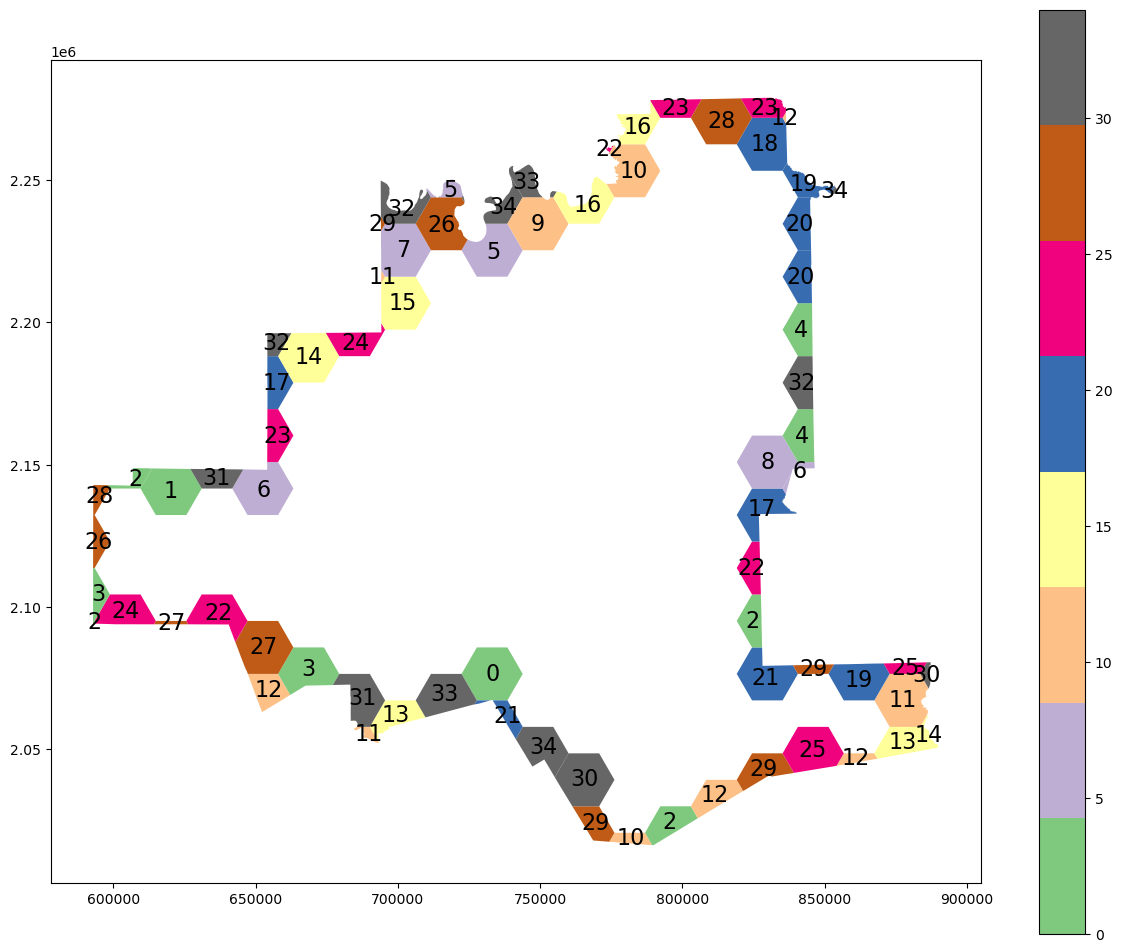

In [14]:
# Plot the hexagons
ax = small_hexagons.plot("group", legend=True, cmap="Accent", figsize=(15, 12))

# Add text labels for each hexagon
for idx, row in small_hexagons.iterrows():
    ax.annotate(text=row["group"], xy=(row.geom.centroid.x, row.geom.centroid.y),
                ha='center', va='center', fontsize=16)

plt.show()

### with distance constraint

In [15]:
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np


In [16]:
def merge_into_groups_with_distance(numbers, target_sum, distance_matrix, distance_weight=0.3, max_iter=100):
    """
    Merge numbers into groups such that each group has a sum closest to the target sum, considering both area and distance.

    Args:
        numbers (list): List of numbers to be grouped.
        target_sum (float): Target sum for each group.
        distance_matrix (numpy.ndarray): Pairwise distance matrix between numbers.
        distance_weight (float): Weight parameter controlling the influence of distance in clustering (0 to 1).
        max_iter (int): Maximum number of iterations to run.

    Returns:
        list: List indicating the group each number belongs to.
    """
    # Initialize groups randomly
    groups = [i % len(numbers) for i in range(len(numbers))]
    
    # Initial group sums
    group_sums = numbers.copy()

    iter_count = 0
    while iter_count < max_iter:
        iter_count += 1

        # Track if any change occurs in this iteration
        changed = False

        for num_idx, num in enumerate(numbers):
            current_group = groups[num_idx]
            current_sum = group_sums[current_group]

            # Calculate the difference if the number is added to the current group
            best_diff = (abs(current_sum - target_sum) / target_sum  )* (1 - distance_weight) # Normalize target sum
            # best_diff = abs(current_sum - target_sum) / target_sum   # Normalize target sum

            best_group = current_group
            for group_idx in set(groups):
                if group_idx!= current_group and group_sums[group_idx] > 0:
                    neighbor_sum = group_sums[group_idx]
                    diff_neighbor_group = abs(neighbor_sum + num - target_sum) / target_sum  # Normalize target sum
                    
                    # Consider distance if distance_weight > 0
                    if distance_weight > 0:
                        if distance_weight == 1:
                            return groups
                        # Find the index of the last element in the group
                        last_in_group_idx = max([i for i, g in enumerate(groups) if g == group_idx])
                        # Retrieve the distance of the last element in the group and normalize
                        distance = distance_matrix[num_idx, last_in_group_idx] / np.max(distance_matrix)
                        # Incorporate distance into the difference calculation
                        # diff_neighbor_group = diff_neighbor_group + (distance_weight / (1-distance_weight)) * distance
                        diff_neighbor_group = diff_neighbor_group * (1 - distance_weight) + distance_weight  * distance

                    if diff_neighbor_group < best_diff:
                        best_diff = diff_neighbor_group
                        best_group = group_idx

            if best_group != current_group:
                # Move the number to the best group
                groups[num_idx] = best_group
                group_sums[current_group] -= num
                group_sums[best_group] += num
                changed = True

        if not changed:
            break

    return numbers,reorder_list(groups)


In [17]:
# centroids = # Extract the centroids of hexagons as a DataFrame with 'x' and 'y' columns
centroids = small_hexagons.centroid.apply(lambda geom: (geom.x, geom.y)).apply(pd.Series)
# Calculate the distance matrix
dist_matrix = cdist(centroids, centroids)

print(dist_matrix.shape)

(74, 74)


In [18]:
def optimize_merge_dist(numbers, target_sum, distance_matrix, distance_weight, max_iter=300, optimize_func=lambda x: max(x) - min(x)):
    best_order, best_group_idx = merge_into_groups_with_distance(numbers, target_sum, distance_matrix, distance_weight)
    group_sum = [x - target_sum for x in calculate_group_sums(numbers, best_group_idx)]
    best_result = optimize_func(group_sum)
    # print(f"group sum: {group_sum}, result: {best_result}")
    # print(f"result: {best_result}")

    best_order_indices = list(range(len(numbers)))
    
    for i in range(max_iter):
        random.shuffle(best_order_indices)  # Shuffle indices instead of numbers
        temp_num = [numbers[idx] for idx in best_order_indices]  # Reorder numbers based on shuffled indices
        # Rearrange distance matrix based on shuffled indices
        temp_distance_matrix = distance_matrix[:, best_order_indices][best_order_indices, :]
        temp_num,temp_group_idx = merge_into_groups_with_distance(temp_num, target_sum, temp_distance_matrix,distance_weight)
        group_sum = [x - target_sum for x in calculate_group_sums(temp_num, temp_group_idx)]
        temp_result = optimize_func(group_sum)
        
        if temp_result < best_result:
            
            # print(f"group sum: {group_sum}, result: {temp_result}")
            # print(f"result: {temp_result}")
            best_result = temp_result
            best_order = temp_num
            best_group_idx = temp_group_idx

    return best_order, best_group_idx

In [19]:
random.seed(1)
distance_weight = 0.5
numbers = list(small_hexagons["area"])
numbers, best_group_idx = optimize_merge_dist(numbers, target_sum ,dist_matrix, distance_weight)
value_to_group = {value: group for value, group in zip(numbers,best_group_idx)}
small_hexagons.loc[:,'group_dist'] = small_hexagons['area'].map(value_to_group)
small_hexagons.loc[:,'group_dist'] = reorder_list(small_hexagons.loc[:,'group_dist'])
df = small_hexagons[["area","group_dist"]].groupby("group_dist").sum()
print(df.shape)
df.describe()

(34, 1)


c:\Users\yyang\.conda\envs\geo\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,area
count,3.400000e+01
mean,3.061849e+08
std,2.579390e+07
min,2.713111e+08
25%,2.851134e+08
50%,3.013152e+08
75%,3.239347e+08
max,3.582264e+08


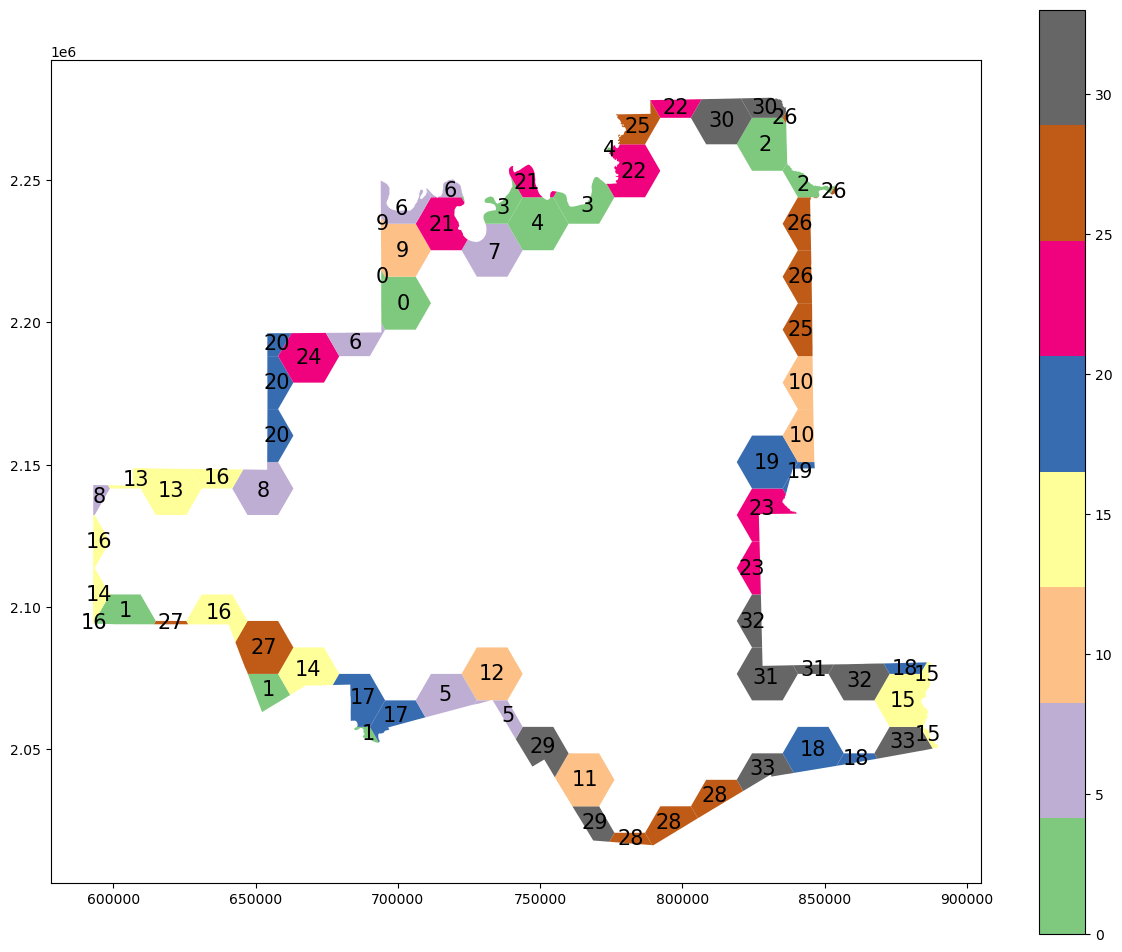

In [20]:
# Plot the hexagons
ax = small_hexagons.plot("group_dist", legend=True, cmap="Accent", figsize=(15, 12))

# Add text labels for each hexagon
for idx, row in small_hexagons.iterrows():
    ax.annotate(text=row["group_dist"], xy=(row.geom.centroid.x, row.geom.centroid.y),
                ha='center', va='center', fontsize=15)

plt.show()

In [25]:
random.seed(1)
distance_weight = 0.8
numbers = list(small_hexagons["area"])
numbers, best_group_idx = optimize_merge_dist(numbers, target_sum ,dist_matrix, distance_weight)
value_to_group = {value: group for value, group in zip(numbers,best_group_idx)}
small_hexagons.loc[:,'group_dist'] = small_hexagons['area'].map(value_to_group)
small_hexagons.loc[:,'group_dist'] = reorder_list(small_hexagons.loc[:,'group_dist'])
df = small_hexagons[["area","group_dist"]].groupby("group_dist").sum()
print(df.shape)
df.describe()

(37, 1)


,area
count,3.700000e+01
mean,2.813591e+08
std,6.500645e+07
min,1.306313e+08
25%,2.549004e+08
50%,2.898252e+08
75%,3.205561e+08
max,3.796024e+08


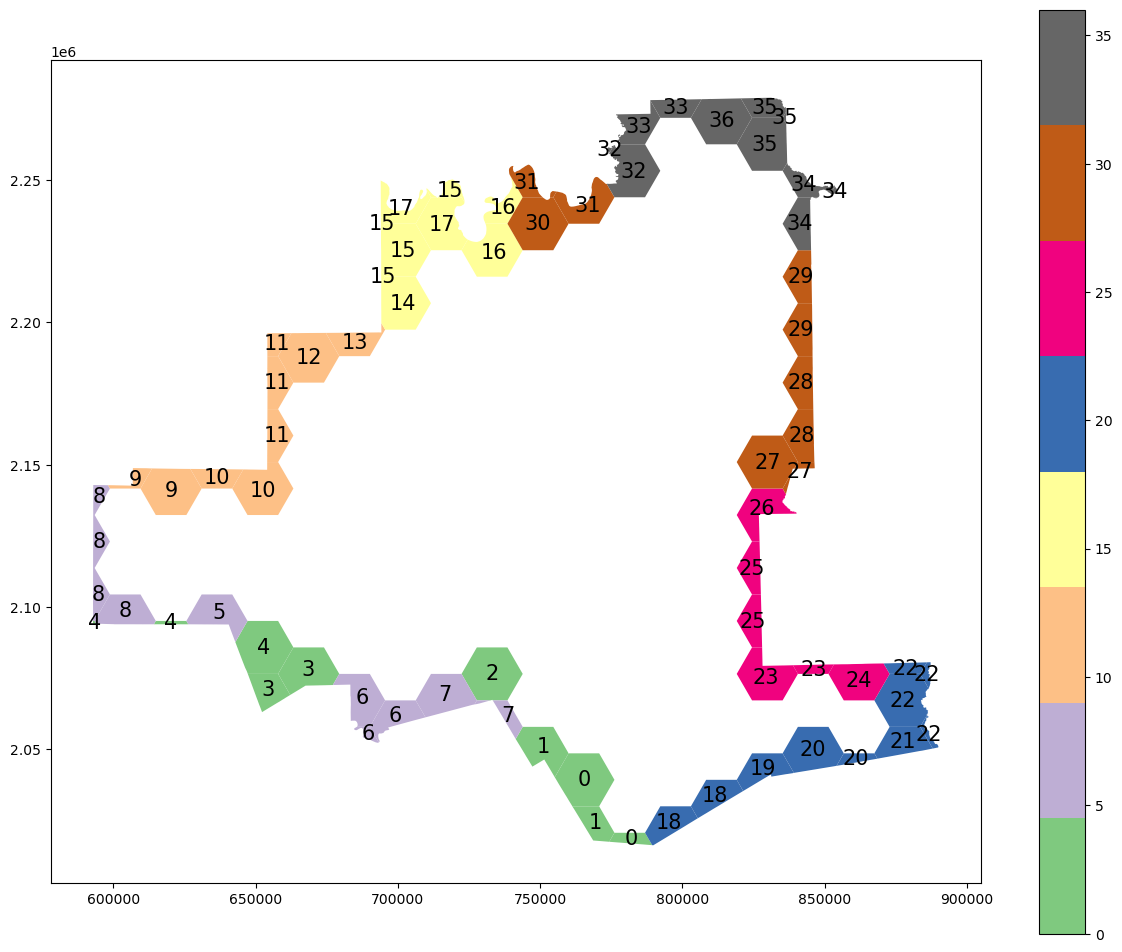

In [26]:
# Plot the hexagons
ax = small_hexagons.plot("group_dist", legend=True, cmap="Accent", figsize=(15, 12))

# Add text labels for each hexagon
for idx, row in small_hexagons.iterrows():
    ax.annotate(text=row["group_dist"], xy=(row.geom.centroid.x, row.geom.centroid.y),
                ha='center', va='center', fontsize=15)

plt.show()